# Hotdog or NotHotdog?
## Using PowerAI to Deploy an iOS Model for CoreML

<strong><a href=https://developer.ibm.com/indexconf/sessions/#!?id=5466>Index 2018 </a></strong>

Yes, really. <a href="https://twitter.com/mccoyjus">Justin McCoy</a> and <a href="https://twitter.com/dokun24">David Okun</a> will walk you through how to use PowerAI in the Cloud with Nimbix, to quickly train and deploy a Model that can tell you whether or not your lunchtime nutritional choice is the right one - all with the camera of the mobile phone in your pocket. All you need are some photos, descriptions of them, and you can be up and running with a model to stream video through in no time flat.

So you want to identify hotdogs, great, summer is just around the corner, and you can never be too careful of what you're eating. 

During this demo we will walk you through the steps, and technologies necessary to train a Deep Learning model using a Convolutional Neural Network, saving it into a format that can be loaded on an iOS device.

I'm sure you've seen the eposide of Silicon Valley, let's get started.


### GPU Resources on the Cloud

![NVIDIA](https://vignette.wikia.nocookie.net/logopedia/images/3/38/Nvidia_logo.png/revision/latest?cb=20120829072950) ![NIMBIX](https://www.nimbix.net/wp-content/uploads/2014/06/LogoRemailer.png)
![POWERAI](https://mp.s81c.com/8034F2C/dal05/v1/AUTH_db1cfc7b-a055-460b-9274-1fd3f11fe689/cbaa77deff9000906b880d05f1a65f4d/hero_55462c4a-dd4c-4d67-ba05-643f030d51b6.png)
Using the <a href="https://www.nimbix.net/app-marketplace/">NIMBIX High Performance Computing Cloud</a>

<a href="https://developer.ibm.com/linuxonpower/deep-learning-powerai/try-powerai/">Signup</a> for a free trial to use IBM"s Latest AI Hardware and get started.

## Agenda
1. Setup Environment 
2. Acquire Data
3. Build Convolutional Neural Network
4. Train Convolutional Neural Network
5. Evaluate Model
6. Make predictions
7. Take a closer look at generated filters
8. Save to CoreML
9. Transfering Learning

# 1. Setup Environment

### Install and import libraries

In [1]:
# Late in this Notebook the Keras Model is converted to Apple's coreML format; only Keras 2.0.4
#  is supported as of creation of this notebook
!sudo pip install keras==2.0.4
!sudo pip install coremltools

The directory '/home/nimbix/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/nimbix/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |������������������������������������������������������������������������������������������������| 204kB 5.2MB/s eta 0:00:01
    100% |������������������������������������������������������������������������������������������������| 2.8MB 416kB/s eta 0:00:01
  Running setup.py install for theano ... done
  Running setup.py install for keras ... done
The directory '/home/nimbix/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please chec

In [2]:
from __future__ import division

import json
from matplotlib import pyplot
import math
import numpy as np
import os
import sys
import time

import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.models import Model
from keras.models import model_from_json
from keras.models import Sequential
from keras.models import load_model

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 

from keras import callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras import backend as K


from tensorflow import Tensor

from keras.engine import InputLayer
import coremltools

%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


### Setup global variables

In [3]:
ITERATION = 1

DATA_PATH = 'hotdog_data'
TRAINING_DATA_PATH = DATA_PATH + '/training_set'
VALIDATION_DATA_PATH = DATA_PATH + '/validation_set'
TEST_DATA_PATH = DATA_PATH + '/test_set'

OUTPUT_PATH = 'output_' + time.strftime("%d-%m-%Y_") + str(ITERATION)
MODEL_JSON_PATH = OUTPUT_PATH + '/seefood_model.json'
MODEL_WEIGHTS_PATH = OUTPUT_PATH + '/seefood_model_weights.h5'
MODEL_EPOCH_PATH = OUTPUT_PATH + '/seefood_weights-{epoch:02d}-{val_acc}.hdf5'

COREML_MODEL_PATH = OUTPUT_PATH + '/seefood_model.mlmodel'
COREML_META_DESCRIPTION = 'SeeFood: Model to classify images as either hotdog or nothotdog'
COREML_META_AUTHOR = 'Justin A. McCoy'
COREML_META_INPUT_DESCRIPTION = 'Image of food that might be a hotdog'


# input image dimensions
IMG_ROWS, IMG_COLS = 128, 128
IMG_CHANNELS = 3

# Number of images gererated at each invocation of the ImageDataGenerator
# Batchsize is an important value when training a CNN. too large a number can lead to out of memory errors, 
#  and lower accuracy. https://arxiv.org/abs/1606.02228 
# When you have a high batch size in compairison to the number of training samples you make bigger jumps during
# graident descent, this can lead you to the minimuma faster but it's possib
BATCH_SIZE = 16

EPOCHS = 50

HOTDOG = 0
NOTHOTDOG = 1

CLASSIFICATION = ['HOTDOG', 'NOTHOTDOG']

### Create output directory

In [4]:
!mkdir "$OUTPUT_PATH"
print('Created path: {}'.format(OUTPUT_PATH))

Created path: output_14-04-2018_1


### Common methods used throughout notebook

In [5]:
def show_images(images, cols=1, title=""):
    """Display a list of images in a single plot with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    """
    n_images = len(images)
    fig = pyplot.figure()
    fig.suptitle(title, fontsize=16)
    for n, image in enumerate(images):
        pyplot.subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        pyplot.imshow(image)
        pyplot.axis('off')
    pyplot.show()
    
    
def get_best_model():
    return load_model(MODEL_WEIGHTS_PATH)

# 2. Acquire Data

### Aquire and classify training data for Hotdogs

There are several places to aquire datasets that are prelabeled. for this example I've used Image.net to aquire images of hotdogs and food items that are not hotdogs

www.image-net.org/

ImageNet is a database of images organized according to the WordNet hierarchy, where each concept described by multiple words is grouped in a 'synonym set'. The synsets are thumbnails of images and contain links to images that have been classified.

A major drawback of ImageNet revolves around where images are located; ImageNet doesn't keep a database of images but links to where images are, or were at one time. ImageNet doesn't save you from the task of cleaning and reviewing your data before jumping into the fun stuff.

#### Downloading images


In [6]:
!wget -L -O hotdog_data.tar.gz https://ibm.box.com/shared/static/ig5ao996ew9mqutfbgs0o2otophuwe1h.gz

--2018-04-14 03:12:37--  https://ibm.box.com/shared/static/ig5ao996ew9mqutfbgs0o2otophuwe1h.gz
Resolving ibm.box.com (ibm.box.com)... 107.152.25.197, 107.152.24.197
Connecting to ibm.box.com (ibm.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/ig5ao996ew9mqutfbgs0o2otophuwe1h.gz [following]
--2018-04-14 03:12:38--  https://ibm.ent.box.com/shared/static/ig5ao996ew9mqutfbgs0o2otophuwe1h.gz
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.24.211, 107.152.25.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.24.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/Ru8eMMI_2MktnZIt_L-uw1pMTSqNwLZxq_Weuxm9tzUjEBtdHanCc569aa1x8lX3kPBUNt5aXu3FMBVJVkSwqebezRwmcDEZ-9Iua278FY5RaIb3M0q3MnzrgD2NlxqoRNMZNemSJ9Vz1SDBCIPHxrJD94mCUVxKaoeSqqcT3_RZe6kQbk468pqB1ZRB5EZg4_qycP0H0jmy1lNCJg8OO-ZAUmZ_Lwd-22b6jVpEqQDRoKaqUlFUaWMBX62O

In [7]:
!tar -xzvf hotdog_data.tar.gz

hotdog_data/
hotdog_data/.DS_Store
hotdog_data/.ipynb_checkpoints/
hotdog_data/test_set/
hotdog_data/test_set/hotdog/
hotdog_data/test_set/hotdog/1000.jpg
hotdog_data/test_set/hotdog/1049.jpg
hotdog_data/test_set/hotdog/1059.jpg
hotdog_data/test_set/hotdog/1060.jpg
hotdog_data/test_set/hotdog/1061.jpg
hotdog_data/test_set/hotdog/1062.jpg
hotdog_data/test_set/hotdog/1076.jpg
hotdog_data/test_set/hotdog/1101.jpg
hotdog_data/test_set/hotdog/1105.jpg
hotdog_data/test_set/hotdog/1111.jpg
hotdog_data/test_set/hotdog/1116.jpg
hotdog_data/test_set/hotdog/1128.jpg
hotdog_data/test_set/hotdog/1129.jpg
hotdog_data/test_set/hotdog/1148.jpg
hotdog_data/test_set/hotdog/1174.jpg
hotdog_data/test_set/hotdog/118.jpg
hotdog_data/test_set/hotdog/1202.jpg
hotdog_data/test_set/hotdog/1203.jpg
hotdog_data/test_set/hotdog/1216.jpg
hotdog_data/test_set/hotdog/122.jpg
hotdog_data/test_set/hotdog/124.jpg
hotdog_data/test_set/hotdog/1248.jpg
hotdog_data/test_set/hotdog/125.jpg
hotdog_data/test_set/hotdog/126.jpg

hotdog_data/test_set/hotdog/912.jpg
hotdog_data/test_set/hotdog/939.jpg
hotdog_data/test_set/hotdog/966.jpg
hotdog_data/test_set/hotdog/967.jpg
hotdog_data/test_set/hotdog/972.jpg
hotdog_data/test_set/hotdog/973.jpg
hotdog_data/test_set/hotdog/th_(14).jpg
hotdog_data/test_set/hotdog/th_(3).jpg
hotdog_data/test_set/hotdog/th_(55).jpg
hotdog_data/test_set/hotdog/th_(79).jpg
hotdog_data/test_set/nothotdog/
hotdog_data/test_set/nothotdog/2198.jpg
hotdog_data/test_set/nothotdog/2220.jpg
hotdog_data/test_set/nothotdog/2234.jpg
hotdog_data/test_set/nothotdog/2247.jpg
hotdog_data/test_set/nothotdog/2327.jpg
hotdog_data/test_set/nothotdog/2354.jpg
hotdog_data/test_set/nothotdog/2359.jpg
hotdog_data/test_set/nothotdog/2368.jpg
hotdog_data/test_set/nothotdog/2371.jpg
hotdog_data/test_set/nothotdog/2397.jpg
hotdog_data/test_set/nothotdog/2403.jpg
hotdog_data/test_set/nothotdog/2417.jpg
hotdog_data/test_set/nothotdog/2432.jpg
hotdog_data/test_set/nothotdog/2441.jpg
hotdog_data/test_set/nothotdog/24

hotdog_data/test_set/nothotdog/4193.jpg
hotdog_data/test_set/nothotdog/4226.jpg
hotdog_data/test_set/nothotdog/4241.jpg
hotdog_data/test_set/nothotdog/4242.jpg
hotdog_data/test_set/nothotdog/4254.jpg
hotdog_data/test_set/nothotdog/4255.jpg
hotdog_data/test_set/nothotdog/4256.jpg
hotdog_data/test_set/nothotdog/4264.jpg
hotdog_data/test_set/nothotdog/4268.jpg
hotdog_data/test_set/nothotdog/4269.jpg
hotdog_data/test_set/nothotdog/4270.jpg
hotdog_data/test_set/nothotdog/4281.jpg
hotdog_data/test_set/nothotdog/4282.jpg
hotdog_data/test_set/nothotdog/4283.jpg
hotdog_data/test_set/nothotdog/4295.jpg
hotdog_data/test_set/nothotdog/4296.jpg
hotdog_data/test_set/nothotdog/4297.jpg
hotdog_data/test_set/nothotdog/4308.jpg
hotdog_data/test_set/nothotdog/4320.jpg
hotdog_data/test_set/nothotdog/4323.jpg
hotdog_data/test_set/nothotdog/4334.jpg
hotdog_data/test_set/nothotdog/4335.jpg
hotdog_data/test_set/nothotdog/4336.jpg
hotdog_data/test_set/nothotdog/cat.1401.jpg
hotdog_data/test_set/nothotdog/cat.1

hotdog_data/training_set/hotdog/6956.jpg
hotdog_data/training_set/hotdog/6958.jpg
hotdog_data/training_set/hotdog/6959.jpg
hotdog_data/training_set/hotdog/6960.jpg
hotdog_data/training_set/hotdog/6962.jpg
hotdog_data/training_set/hotdog/6963.jpg
hotdog_data/training_set/hotdog/6964.jpg
hotdog_data/training_set/hotdog/6966.jpg
hotdog_data/training_set/hotdog/6969.jpg
hotdog_data/training_set/hotdog/6971.jpg
hotdog_data/training_set/hotdog/6972.jpg
hotdog_data/training_set/hotdog/6974.jpg
hotdog_data/training_set/hotdog/6976.jpg
hotdog_data/training_set/hotdog/6980.jpg
hotdog_data/training_set/hotdog/6981.jpg
hotdog_data/training_set/hotdog/6983.jpg
hotdog_data/training_set/hotdog/6987.jpg
hotdog_data/training_set/hotdog/6994.jpg
hotdog_data/training_set/hotdog/6998.jpg
hotdog_data/training_set/hotdog/8000.jpg
hotdog_data/training_set/hotdog/8001.jpg
hotdog_data/training_set/hotdog/8003.jpg
hotdog_data/training_set/hotdog/8004.jpg
hotdog_data/training_set/hotdog/8011.jpg
hotdog_data/trai

hotdog_data/training_set/hotdog/8360.jpg
hotdog_data/training_set/hotdog/8368.jpg
hotdog_data/training_set/hotdog/8371.jpg
hotdog_data/training_set/hotdog/8374.jpg
hotdog_data/training_set/hotdog/8379.jpg
hotdog_data/training_set/hotdog/8385.jpg
hotdog_data/training_set/hotdog/8386.jpg
hotdog_data/training_set/hotdog/8388.jpg
hotdog_data/training_set/hotdog/8391.jpg
hotdog_data/training_set/hotdog/8395.jpg
hotdog_data/training_set/hotdog/8396.jpg
hotdog_data/training_set/hotdog/8397.jpg
hotdog_data/training_set/hotdog/8399.jpg
hotdog_data/training_set/hotdog/8400.jpg
hotdog_data/training_set/hotdog/8401.jpg
hotdog_data/training_set/hotdog/8402.jpg
hotdog_data/training_set/hotdog/8403.jpg
hotdog_data/training_set/hotdog/8406.jpg
hotdog_data/training_set/hotdog/8407.jpg
hotdog_data/training_set/hotdog/8409.jpg
hotdog_data/training_set/hotdog/8410.jpg
hotdog_data/training_set/hotdog/8411.jpg
hotdog_data/training_set/hotdog/8413.jpg
hotdog_data/training_set/hotdog/8417.jpg
hotdog_data/trai

hotdog_data/training_set/hotdog/8736.jpg
hotdog_data/training_set/hotdog/8740.jpg
hotdog_data/training_set/hotdog/8741.jpg
hotdog_data/training_set/hotdog/8744.jpg
hotdog_data/training_set/hotdog/8747.jpg
hotdog_data/training_set/hotdog/8752.jpg
hotdog_data/training_set/hotdog/8756.jpg
hotdog_data/training_set/hotdog/8757.jpg
hotdog_data/training_set/hotdog/8758.jpg
hotdog_data/training_set/hotdog/8759.jpg
hotdog_data/training_set/hotdog/8762.jpg
hotdog_data/training_set/hotdog/8765.jpg
hotdog_data/training_set/hotdog/8767.jpg
hotdog_data/training_set/hotdog/8768.jpg
hotdog_data/training_set/hotdog/8774.jpg
hotdog_data/training_set/hotdog/8778.jpg
hotdog_data/training_set/hotdog/8779.jpg
hotdog_data/training_set/hotdog/8780.jpg
hotdog_data/training_set/hotdog/8783.jpg
hotdog_data/training_set/hotdog/8784.jpg
hotdog_data/training_set/hotdog/8786.jpg
hotdog_data/training_set/hotdog/8787.jpg
hotdog_data/training_set/hotdog/8788.jpg
hotdog_data/training_set/hotdog/8789.jpg
hotdog_data/trai

hotdog_data/training_set/hotdog/9148.jpg
hotdog_data/training_set/hotdog/9149.jpg
hotdog_data/training_set/hotdog/9151.jpg
hotdog_data/training_set/hotdog/9153.jpg
hotdog_data/training_set/hotdog/9155.jpg
hotdog_data/training_set/hotdog/9156.jpg
hotdog_data/training_set/hotdog/9157.jpg
hotdog_data/training_set/hotdog/9159.jpg
hotdog_data/training_set/hotdog/9160.jpg
hotdog_data/training_set/hotdog/9162.jpg
hotdog_data/training_set/hotdog/9163.jpg
hotdog_data/training_set/hotdog/9165.jpg
hotdog_data/training_set/hotdog/9166.jpg
hotdog_data/training_set/hotdog/9168.jpg
hotdog_data/training_set/hotdog/9171.jpg
hotdog_data/training_set/hotdog/9172.jpg
hotdog_data/training_set/hotdog/9173.jpg
hotdog_data/training_set/hotdog/9174.jpg
hotdog_data/training_set/hotdog/9175.jpg
hotdog_data/training_set/hotdog/9176.jpg
hotdog_data/training_set/hotdog/9178.jpg
hotdog_data/training_set/hotdog/9181.jpg
hotdog_data/training_set/hotdog/9183.jpg
hotdog_data/training_set/hotdog/9184.jpg
hotdog_data/trai

hotdog_data/training_set/hotdog/9545.jpg
hotdog_data/training_set/hotdog/9548.jpg
hotdog_data/training_set/hotdog/9549.jpg
hotdog_data/training_set/hotdog/9551.jpg
hotdog_data/training_set/hotdog/9553.jpg
hotdog_data/training_set/hotdog/9554.jpg
hotdog_data/training_set/hotdog/9556.jpg
hotdog_data/training_set/hotdog/9557.jpg
hotdog_data/training_set/hotdog/9559.jpg
hotdog_data/training_set/hotdog/9560.jpg
hotdog_data/training_set/hotdog/9562.jpg
hotdog_data/training_set/hotdog/9565.jpg
hotdog_data/training_set/hotdog/9566.jpg
hotdog_data/training_set/hotdog/9569.jpg
hotdog_data/training_set/hotdog/9573.jpg
hotdog_data/training_set/hotdog/9574.jpg
hotdog_data/training_set/hotdog/9575.jpg
hotdog_data/training_set/hotdog/9576.jpg
hotdog_data/training_set/hotdog/9579.jpg
hotdog_data/training_set/hotdog/9580.jpg
hotdog_data/training_set/hotdog/9582.jpg
hotdog_data/training_set/hotdog/9583.jpg
hotdog_data/training_set/hotdog/9585.jpg
hotdog_data/training_set/hotdog/9588.jpg
hotdog_data/trai

hotdog_data/training_set/hotdog/9947.jpg
hotdog_data/training_set/hotdog/9948.jpg
hotdog_data/training_set/hotdog/9949.jpg
hotdog_data/training_set/hotdog/9951.jpg
hotdog_data/training_set/hotdog/9952.jpg
hotdog_data/training_set/hotdog/9953.jpg
hotdog_data/training_set/hotdog/9954.jpg
hotdog_data/training_set/hotdog/9955.jpg
hotdog_data/training_set/hotdog/9957.jpg
hotdog_data/training_set/hotdog/9959.jpg
hotdog_data/training_set/hotdog/9960.jpg
hotdog_data/training_set/hotdog/9963.jpg
hotdog_data/training_set/hotdog/9964.jpg
hotdog_data/training_set/hotdog/9966.jpg
hotdog_data/training_set/hotdog/9967.jpg
hotdog_data/training_set/hotdog/9968.jpg
hotdog_data/training_set/hotdog/9969.jpg
hotdog_data/training_set/hotdog/9971.jpg
hotdog_data/training_set/hotdog/9972.jpg
hotdog_data/training_set/hotdog/9975.jpg
hotdog_data/training_set/hotdog/9976.jpg
hotdog_data/training_set/hotdog/9978.jpg
hotdog_data/training_set/hotdog/9979.jpg
hotdog_data/training_set/hotdog/9982.jpg
hotdog_data/trai

hotdog_data/training_set/hotdog/hotdog_216 copy.jpg
hotdog_data/training_set/hotdog/hotdog_216.jpg
hotdog_data/training_set/hotdog/hotdog_217.jpg
hotdog_data/training_set/hotdog/hotdog_218.jpg
hotdog_data/training_set/hotdog/hotdog_219 copy.jpg
hotdog_data/training_set/hotdog/hotdog_219.jpg
hotdog_data/training_set/hotdog/hotdog_220 copy.jpg
hotdog_data/training_set/hotdog/hotdog_220.jpg
hotdog_data/training_set/hotdog/hotdog_221 copy.jpg
hotdog_data/training_set/hotdog/hotdog_221.jpg
hotdog_data/training_set/hotdog/hotdog_222 copy.jpg
hotdog_data/training_set/hotdog/hotdog_222.jpg
hotdog_data/training_set/hotdog/hotdog_223 copy.jpg
hotdog_data/training_set/hotdog/hotdog_223.jpg
hotdog_data/training_set/hotdog/hotdog_224 copy.jpg
hotdog_data/training_set/hotdog/hotdog_224.jpg
hotdog_data/training_set/hotdog/hotdog_225 copy.jpg
hotdog_data/training_set/hotdog/hotdog_225.jpg
hotdog_data/training_set/hotdog/hotdog_226 copy.jpg
hotdog_data/training_set/hotdog/hotdog_226.jpg
hotdog_data/tra

hotdog_data/training_set/hotdog/hotdog_365.jpg
hotdog_data/training_set/hotdog/hotdog_366 copy.jpg
hotdog_data/training_set/hotdog/hotdog_366.jpg
hotdog_data/training_set/hotdog/hotdog_367 copy.jpg
hotdog_data/training_set/hotdog/hotdog_367.jpg
hotdog_data/training_set/hotdog/hotdog_368 copy.jpg
hotdog_data/training_set/hotdog/hotdog_368.jpg
hotdog_data/training_set/hotdog/hotdog_369 copy.jpg
hotdog_data/training_set/hotdog/hotdog_369.jpg
hotdog_data/training_set/hotdog/hotdog_370 copy.jpg
hotdog_data/training_set/hotdog/hotdog_370.jpg
hotdog_data/training_set/hotdog/hotdog_371 copy.jpg
hotdog_data/training_set/hotdog/hotdog_371.jpg
hotdog_data/training_set/hotdog/hotdog_372 copy.jpg
hotdog_data/training_set/hotdog/hotdog_372.jpg
hotdog_data/training_set/hotdog/hotdog_373 copy.jpg
hotdog_data/training_set/hotdog/hotdog_373.jpg
hotdog_data/training_set/hotdog/hotdog_374 copy.jpg
hotdog_data/training_set/hotdog/hotdog_374.jpg
hotdog_data/training_set/hotdog/hotdog_375 copy.jpg
hotdog_dat

hotdog_data/training_set/hotdog/hotdog_525 copy.jpg
hotdog_data/training_set/hotdog/hotdog_525.jpg
hotdog_data/training_set/hotdog/hotdog_526 copy.jpg
hotdog_data/training_set/hotdog/hotdog_526.jpg
hotdog_data/training_set/hotdog/hotdog_527 copy.jpg
hotdog_data/training_set/hotdog/hotdog_527.jpg
hotdog_data/training_set/hotdog/hotdog_528.jpg
hotdog_data/training_set/hotdog/hotdog_529 copy.jpg
hotdog_data/training_set/hotdog/hotdog_529.jpg
hotdog_data/training_set/hotdog/hotdog_530 copy.jpg
hotdog_data/training_set/hotdog/hotdog_530.jpg
hotdog_data/training_set/hotdog/hotdog_531 copy.jpg
hotdog_data/training_set/hotdog/hotdog_531.jpg
hotdog_data/training_set/hotdog/hotdog_532 copy.jpg
hotdog_data/training_set/hotdog/hotdog_532.jpg
hotdog_data/training_set/hotdog/hotdog_533 copy.jpg
hotdog_data/training_set/hotdog/hotdog_533.jpg
hotdog_data/training_set/hotdog/hotdog_534 copy.jpg
hotdog_data/training_set/hotdog/hotdog_534.jpg
hotdog_data/training_set/hotdog/hotdog_535 copy.jpg
hotdog_dat

hotdog_data/training_set/not-hotdog/1097.jpg
hotdog_data/training_set/not-hotdog/1098.jpg
hotdog_data/training_set/not-hotdog/1099.jpg
hotdog_data/training_set/not-hotdog/11.jpg
hotdog_data/training_set/not-hotdog/110.jpg
hotdog_data/training_set/not-hotdog/1100.jpg
hotdog_data/training_set/not-hotdog/1101.jpg
hotdog_data/training_set/not-hotdog/1102.jpg
hotdog_data/training_set/not-hotdog/1103.jpg
hotdog_data/training_set/not-hotdog/1104.jpg
hotdog_data/training_set/not-hotdog/1105.jpg
hotdog_data/training_set/not-hotdog/1106.jpg
hotdog_data/training_set/not-hotdog/1107.jpg
hotdog_data/training_set/not-hotdog/1108.jpg
hotdog_data/training_set/not-hotdog/1109.jpg
hotdog_data/training_set/not-hotdog/111.jpg
hotdog_data/training_set/not-hotdog/1110.jpg
hotdog_data/training_set/not-hotdog/1111.jpg
hotdog_data/training_set/not-hotdog/1112.jpg
hotdog_data/training_set/not-hotdog/1114.jpg
hotdog_data/training_set/not-hotdog/1115.jpg
hotdog_data/training_set/not-hotdog/1116.jpg
hotdog_data/tr

hotdog_data/training_set/not-hotdog/1337.jpg
hotdog_data/training_set/not-hotdog/1338.jpg
hotdog_data/training_set/not-hotdog/1339.jpg
hotdog_data/training_set/not-hotdog/134.jpg
hotdog_data/training_set/not-hotdog/1341.jpg
hotdog_data/training_set/not-hotdog/1343.jpg
hotdog_data/training_set/not-hotdog/1344.jpg
hotdog_data/training_set/not-hotdog/1345.jpg
hotdog_data/training_set/not-hotdog/1346.jpg
hotdog_data/training_set/not-hotdog/1348.jpg
hotdog_data/training_set/not-hotdog/1349.jpg
hotdog_data/training_set/not-hotdog/135.jpg
hotdog_data/training_set/not-hotdog/1350.jpg
hotdog_data/training_set/not-hotdog/1351.jpg
hotdog_data/training_set/not-hotdog/1352.jpg
hotdog_data/training_set/not-hotdog/1353.jpg
hotdog_data/training_set/not-hotdog/1354.jpg
hotdog_data/training_set/not-hotdog/1355.jpg
hotdog_data/training_set/not-hotdog/1357.jpg
hotdog_data/training_set/not-hotdog/1359.jpg
hotdog_data/training_set/not-hotdog/136.jpg
hotdog_data/training_set/not-hotdog/1360.jpg
hotdog_data/t

hotdog_data/training_set/not-hotdog/1575.jpg
hotdog_data/training_set/not-hotdog/1576.jpg
hotdog_data/training_set/not-hotdog/1577.jpg
hotdog_data/training_set/not-hotdog/1578.jpg
hotdog_data/training_set/not-hotdog/1579.jpg
hotdog_data/training_set/not-hotdog/158.jpg
hotdog_data/training_set/not-hotdog/1580.jpg
hotdog_data/training_set/not-hotdog/1581.jpg
hotdog_data/training_set/not-hotdog/1582.jpg
hotdog_data/training_set/not-hotdog/1583.jpg
hotdog_data/training_set/not-hotdog/1584.jpg
hotdog_data/training_set/not-hotdog/1585.jpg
hotdog_data/training_set/not-hotdog/1587.jpg
hotdog_data/training_set/not-hotdog/1588.jpg
hotdog_data/training_set/not-hotdog/1589.jpg
hotdog_data/training_set/not-hotdog/159.jpg
hotdog_data/training_set/not-hotdog/1590.jpg
hotdog_data/training_set/not-hotdog/1591.jpg
hotdog_data/training_set/not-hotdog/1592.jpg
hotdog_data/training_set/not-hotdog/1593.jpg
hotdog_data/training_set/not-hotdog/1594.jpg
hotdog_data/training_set/not-hotdog/1595.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/3285.jpg
hotdog_data/training_set/not-hotdog/3286.jpg
hotdog_data/training_set/not-hotdog/3287.jpg
hotdog_data/training_set/not-hotdog/3288.jpg
hotdog_data/training_set/not-hotdog/3289.jpg
hotdog_data/training_set/not-hotdog/329.jpg
hotdog_data/training_set/not-hotdog/3291.jpg
hotdog_data/training_set/not-hotdog/3292.jpg
hotdog_data/training_set/not-hotdog/3293.jpg
hotdog_data/training_set/not-hotdog/3294.jpg
hotdog_data/training_set/not-hotdog/3296.jpg
hotdog_data/training_set/not-hotdog/3297.jpg
hotdog_data/training_set/not-hotdog/3298.jpg
hotdog_data/training_set/not-hotdog/3299.jpg
hotdog_data/training_set/not-hotdog/33.jpg
hotdog_data/training_set/not-hotdog/330.jpg
hotdog_data/training_set/not-hotdog/3301.jpg
hotdog_data/training_set/not-hotdog/3302.jpg
hotdog_data/training_set/not-hotdog/3303.jpg
hotdog_data/training_set/not-hotdog/3304.jpg
hotdog_data/training_set/not-hotdog/3305.jpg
hotdog_data/training_set/not-hotdog/3307.jpg
hotdog_data/tr

hotdog_data/training_set/not-hotdog/3532.jpg
hotdog_data/training_set/not-hotdog/3533.jpg
hotdog_data/training_set/not-hotdog/3534.jpg
hotdog_data/training_set/not-hotdog/3535.jpg
hotdog_data/training_set/not-hotdog/3536.jpg
hotdog_data/training_set/not-hotdog/3537.jpg
hotdog_data/training_set/not-hotdog/3538.jpg
hotdog_data/training_set/not-hotdog/3539.jpg
hotdog_data/training_set/not-hotdog/354.jpg
hotdog_data/training_set/not-hotdog/3541.jpg
hotdog_data/training_set/not-hotdog/3542.jpg
hotdog_data/training_set/not-hotdog/3543.jpg
hotdog_data/training_set/not-hotdog/3545.jpg
hotdog_data/training_set/not-hotdog/3546.jpg
hotdog_data/training_set/not-hotdog/3547.jpg
hotdog_data/training_set/not-hotdog/3548.jpg
hotdog_data/training_set/not-hotdog/3549.jpg
hotdog_data/training_set/not-hotdog/355.jpg
hotdog_data/training_set/not-hotdog/3550.jpg
hotdog_data/training_set/not-hotdog/3551.jpg
hotdog_data/training_set/not-hotdog/3552.jpg
hotdog_data/training_set/not-hotdog/3553.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/3787.jpg
hotdog_data/training_set/not-hotdog/3788.jpg
hotdog_data/training_set/not-hotdog/3789.jpg
hotdog_data/training_set/not-hotdog/3790.jpg
hotdog_data/training_set/not-hotdog/3791.jpg
hotdog_data/training_set/not-hotdog/3792.jpg
hotdog_data/training_set/not-hotdog/3795.jpg
hotdog_data/training_set/not-hotdog/3796.jpg
hotdog_data/training_set/not-hotdog/3797.jpg
hotdog_data/training_set/not-hotdog/3798.jpg
hotdog_data/training_set/not-hotdog/38.jpg
hotdog_data/training_set/not-hotdog/380.jpg
hotdog_data/training_set/not-hotdog/3800.jpg
hotdog_data/training_set/not-hotdog/3801.jpg
hotdog_data/training_set/not-hotdog/3802.jpg
hotdog_data/training_set/not-hotdog/3803.jpg
hotdog_data/training_set/not-hotdog/3804.jpg
hotdog_data/training_set/not-hotdog/3808.jpg
hotdog_data/training_set/not-hotdog/3809.jpg
hotdog_data/training_set/not-hotdog/381.jpg
hotdog_data/training_set/not-hotdog/3810.jpg
hotdog_data/training_set/not-hotdog/3811.jpg
hotdog_data/tr

hotdog_data/training_set/not-hotdog/4002.jpg
hotdog_data/training_set/not-hotdog/4003.jpg
hotdog_data/training_set/not-hotdog/4004.jpg
hotdog_data/training_set/not-hotdog/4005.jpg
hotdog_data/training_set/not-hotdog/4006.jpg
hotdog_data/training_set/not-hotdog/4007.jpg
hotdog_data/training_set/not-hotdog/4008.jpg
hotdog_data/training_set/not-hotdog/4009.jpg
hotdog_data/training_set/not-hotdog/401.jpg
hotdog_data/training_set/not-hotdog/4010.jpg
hotdog_data/training_set/not-hotdog/4011.jpg
hotdog_data/training_set/not-hotdog/4012.jpg
hotdog_data/training_set/not-hotdog/4013.jpg
hotdog_data/training_set/not-hotdog/4014.jpg
hotdog_data/training_set/not-hotdog/4015.jpg
hotdog_data/training_set/not-hotdog/4016.jpg
hotdog_data/training_set/not-hotdog/4017.jpg
hotdog_data/training_set/not-hotdog/4018.jpg
hotdog_data/training_set/not-hotdog/4019.jpg
hotdog_data/training_set/not-hotdog/402.jpg
hotdog_data/training_set/not-hotdog/4022.jpg
hotdog_data/training_set/not-hotdog/4023.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/4213.jpg
hotdog_data/training_set/not-hotdog/4214.jpg
hotdog_data/training_set/not-hotdog/4215.jpg
hotdog_data/training_set/not-hotdog/4216.jpg
hotdog_data/training_set/not-hotdog/4218.jpg
hotdog_data/training_set/not-hotdog/4219.jpg
hotdog_data/training_set/not-hotdog/422.jpg
hotdog_data/training_set/not-hotdog/4220.jpg
hotdog_data/training_set/not-hotdog/4221.jpg
hotdog_data/training_set/not-hotdog/4223.jpg
hotdog_data/training_set/not-hotdog/4225.jpg
hotdog_data/training_set/not-hotdog/4227.jpg
hotdog_data/training_set/not-hotdog/4228.jpg
hotdog_data/training_set/not-hotdog/4229.jpg
hotdog_data/training_set/not-hotdog/423.jpg
hotdog_data/training_set/not-hotdog/4230.jpg
hotdog_data/training_set/not-hotdog/4231.jpg
hotdog_data/training_set/not-hotdog/4233.jpg
hotdog_data/training_set/not-hotdog/4235.jpg
hotdog_data/training_set/not-hotdog/4236.jpg
hotdog_data/training_set/not-hotdog/4237.jpg
hotdog_data/training_set/not-hotdog/4238.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/4435.jpg
hotdog_data/training_set/not-hotdog/4436.jpg
hotdog_data/training_set/not-hotdog/4437.jpg
hotdog_data/training_set/not-hotdog/4438.jpg
hotdog_data/training_set/not-hotdog/4439.jpg
hotdog_data/training_set/not-hotdog/444.jpg
hotdog_data/training_set/not-hotdog/4440.jpg
hotdog_data/training_set/not-hotdog/4441.jpg
hotdog_data/training_set/not-hotdog/4442.jpg
hotdog_data/training_set/not-hotdog/4443.jpg
hotdog_data/training_set/not-hotdog/4448.jpg
hotdog_data/training_set/not-hotdog/4449.jpg
hotdog_data/training_set/not-hotdog/445.jpg
hotdog_data/training_set/not-hotdog/4450.jpg
hotdog_data/training_set/not-hotdog/4451.jpg
hotdog_data/training_set/not-hotdog/4452.jpg
hotdog_data/training_set/not-hotdog/4453.jpg
hotdog_data/training_set/not-hotdog/4454.jpg
hotdog_data/training_set/not-hotdog/4456.jpg
hotdog_data/training_set/not-hotdog/4457.jpg
hotdog_data/training_set/not-hotdog/4458.jpg
hotdog_data/training_set/not-hotdog/4459.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/4656.jpg
hotdog_data/training_set/not-hotdog/4657.jpg
hotdog_data/training_set/not-hotdog/4658.jpg
hotdog_data/training_set/not-hotdog/4659.jpg
hotdog_data/training_set/not-hotdog/466.jpg
hotdog_data/training_set/not-hotdog/4660.jpg
hotdog_data/training_set/not-hotdog/4662.jpg
hotdog_data/training_set/not-hotdog/4663.jpg
hotdog_data/training_set/not-hotdog/4665.jpg
hotdog_data/training_set/not-hotdog/4666.jpg
hotdog_data/training_set/not-hotdog/4667.jpg
hotdog_data/training_set/not-hotdog/4669.jpg
hotdog_data/training_set/not-hotdog/4672.jpg
hotdog_data/training_set/not-hotdog/4674.jpg
hotdog_data/training_set/not-hotdog/4675.jpg
hotdog_data/training_set/not-hotdog/4676.jpg
hotdog_data/training_set/not-hotdog/4679.jpg
hotdog_data/training_set/not-hotdog/468.jpg
hotdog_data/training_set/not-hotdog/4680.jpg
hotdog_data/training_set/not-hotdog/4681.jpg
hotdog_data/training_set/not-hotdog/4684.jpg
hotdog_data/training_set/not-hotdog/4685.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/489.jpg
hotdog_data/training_set/not-hotdog/4892.jpg
hotdog_data/training_set/not-hotdog/4894.jpg
hotdog_data/training_set/not-hotdog/4895.jpg
hotdog_data/training_set/not-hotdog/4896.jpg
hotdog_data/training_set/not-hotdog/4898.jpg
hotdog_data/training_set/not-hotdog/4899.jpg
hotdog_data/training_set/not-hotdog/49.jpg
hotdog_data/training_set/not-hotdog/490.jpg
hotdog_data/training_set/not-hotdog/4900.jpg
hotdog_data/training_set/not-hotdog/4904.jpg
hotdog_data/training_set/not-hotdog/4905.jpg
hotdog_data/training_set/not-hotdog/4907.jpg
hotdog_data/training_set/not-hotdog/4908.jpg
hotdog_data/training_set/not-hotdog/4909.jpg
hotdog_data/training_set/not-hotdog/491.jpg
hotdog_data/training_set/not-hotdog/4911.jpg
hotdog_data/training_set/not-hotdog/4912.jpg
hotdog_data/training_set/not-hotdog/4913.jpg
hotdog_data/training_set/not-hotdog/4914.jpg
hotdog_data/training_set/not-hotdog/4915.jpg
hotdog_data/training_set/not-hotdog/4916.jpg
hotdog_data/tra

hotdog_data/training_set/not-hotdog/511.jpg
hotdog_data/training_set/not-hotdog/5110.jpg
hotdog_data/training_set/not-hotdog/5111.jpg
hotdog_data/training_set/not-hotdog/5112.jpg
hotdog_data/training_set/not-hotdog/5115.jpg
hotdog_data/training_set/not-hotdog/5116.jpg
hotdog_data/training_set/not-hotdog/5117.jpg
hotdog_data/training_set/not-hotdog/5118.jpg
hotdog_data/training_set/not-hotdog/5119.jpg
hotdog_data/training_set/not-hotdog/5120.jpg
hotdog_data/training_set/not-hotdog/5121.jpg
hotdog_data/training_set/not-hotdog/5122.jpg
hotdog_data/training_set/not-hotdog/5123.jpg
hotdog_data/training_set/not-hotdog/5124.jpg
hotdog_data/training_set/not-hotdog/5125.jpg
hotdog_data/training_set/not-hotdog/5126.jpg
hotdog_data/training_set/not-hotdog/5129.jpg
hotdog_data/training_set/not-hotdog/513.jpg
hotdog_data/training_set/not-hotdog/5131.jpg
hotdog_data/training_set/not-hotdog/5132.jpg
hotdog_data/training_set/not-hotdog/5134.jpg
hotdog_data/training_set/not-hotdog/5136.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/5383.jpg
hotdog_data/training_set/not-hotdog/5384.jpg
hotdog_data/training_set/not-hotdog/5385.jpg
hotdog_data/training_set/not-hotdog/5387.jpg
hotdog_data/training_set/not-hotdog/5388.jpg
hotdog_data/training_set/not-hotdog/5389.jpg
hotdog_data/training_set/not-hotdog/539.jpg
hotdog_data/training_set/not-hotdog/5390.jpg
hotdog_data/training_set/not-hotdog/5391.jpg
hotdog_data/training_set/not-hotdog/5392.jpg
hotdog_data/training_set/not-hotdog/5394.jpg
hotdog_data/training_set/not-hotdog/5395.jpg
hotdog_data/training_set/not-hotdog/5396.jpg
hotdog_data/training_set/not-hotdog/5397.jpg
hotdog_data/training_set/not-hotdog/5399.jpg
hotdog_data/training_set/not-hotdog/54.jpg
hotdog_data/training_set/not-hotdog/540.jpg
hotdog_data/training_set/not-hotdog/5400.jpg
hotdog_data/training_set/not-hotdog/5402.jpg
hotdog_data/training_set/not-hotdog/5404.jpg
hotdog_data/training_set/not-hotdog/5405.jpg
hotdog_data/training_set/not-hotdog/5406.jpg
hotdog_data/tr

hotdog_data/training_set/not-hotdog/5598.jpg
hotdog_data/training_set/not-hotdog/5599.jpg
hotdog_data/training_set/not-hotdog/56.jpg
hotdog_data/training_set/not-hotdog/560.jpg
hotdog_data/training_set/not-hotdog/5600.jpg
hotdog_data/training_set/not-hotdog/5602.jpg
hotdog_data/training_set/not-hotdog/5603.jpg
hotdog_data/training_set/not-hotdog/5604.jpg
hotdog_data/training_set/not-hotdog/5605.jpg
hotdog_data/training_set/not-hotdog/5606.jpg
hotdog_data/training_set/not-hotdog/5607.jpg
hotdog_data/training_set/not-hotdog/5608.jpg
hotdog_data/training_set/not-hotdog/5609.jpg
hotdog_data/training_set/not-hotdog/561.jpg
hotdog_data/training_set/not-hotdog/5610.jpg
hotdog_data/training_set/not-hotdog/5611.jpg
hotdog_data/training_set/not-hotdog/5612.jpg
hotdog_data/training_set/not-hotdog/5613.jpg
hotdog_data/training_set/not-hotdog/5614.jpg
hotdog_data/training_set/not-hotdog/5615.jpg
hotdog_data/training_set/not-hotdog/5616.jpg
hotdog_data/training_set/not-hotdog/5617.jpg
hotdog_data/tr

hotdog_data/training_set/not-hotdog/5814.jpg
hotdog_data/training_set/not-hotdog/5815.jpg
hotdog_data/training_set/not-hotdog/5817.jpg
hotdog_data/training_set/not-hotdog/5818.jpg
hotdog_data/training_set/not-hotdog/5819.jpg
hotdog_data/training_set/not-hotdog/582.jpg
hotdog_data/training_set/not-hotdog/5820.jpg
hotdog_data/training_set/not-hotdog/5821.jpg
hotdog_data/training_set/not-hotdog/5822.jpg
hotdog_data/training_set/not-hotdog/5823.jpg
hotdog_data/training_set/not-hotdog/5824.jpg
hotdog_data/training_set/not-hotdog/5826.jpg
hotdog_data/training_set/not-hotdog/5827.jpg
hotdog_data/training_set/not-hotdog/5828.jpg
hotdog_data/training_set/not-hotdog/5829.jpg
hotdog_data/training_set/not-hotdog/583.jpg
hotdog_data/training_set/not-hotdog/5830.jpg
hotdog_data/training_set/not-hotdog/5831.jpg
hotdog_data/training_set/not-hotdog/5832.jpg
hotdog_data/training_set/not-hotdog/5833.jpg
hotdog_data/training_set/not-hotdog/5834.jpg
hotdog_data/training_set/not-hotdog/5835.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/6023.jpg
hotdog_data/training_set/not-hotdog/6024.jpg
hotdog_data/training_set/not-hotdog/6025.jpg
hotdog_data/training_set/not-hotdog/6026.jpg
hotdog_data/training_set/not-hotdog/6027.jpg
hotdog_data/training_set/not-hotdog/6028.jpg
hotdog_data/training_set/not-hotdog/6029.jpg
hotdog_data/training_set/not-hotdog/603.jpg
hotdog_data/training_set/not-hotdog/6030.jpg
hotdog_data/training_set/not-hotdog/6031.jpg
hotdog_data/training_set/not-hotdog/6032.jpg
hotdog_data/training_set/not-hotdog/6033.jpg
hotdog_data/training_set/not-hotdog/6035.jpg
hotdog_data/training_set/not-hotdog/6036.jpg
hotdog_data/training_set/not-hotdog/6037.jpg
hotdog_data/training_set/not-hotdog/6038.jpg
hotdog_data/training_set/not-hotdog/6039.jpg
hotdog_data/training_set/not-hotdog/604.jpg
hotdog_data/training_set/not-hotdog/6041.jpg
hotdog_data/training_set/not-hotdog/6042.jpg
hotdog_data/training_set/not-hotdog/6043.jpg
hotdog_data/training_set/not-hotdog/6044.jpg
hotdog_data/

hotdog_data/training_set/not-hotdog/6239.jpg
hotdog_data/training_set/not-hotdog/624.jpg
hotdog_data/training_set/not-hotdog/6242.jpg
hotdog_data/training_set/not-hotdog/6243.jpg
hotdog_data/training_set/not-hotdog/6245.jpg
hotdog_data/training_set/not-hotdog/6246.jpg
hotdog_data/training_set/not-hotdog/6247.jpg
hotdog_data/training_set/not-hotdog/6249.jpg
hotdog_data/training_set/not-hotdog/625.jpg
hotdog_data/training_set/not-hotdog/6250.jpg
hotdog_data/training_set/not-hotdog/6251.jpg
hotdog_data/training_set/not-hotdog/6252.jpg
hotdog_data/training_set/not-hotdog/6253.jpg
hotdog_data/training_set/not-hotdog/6254.jpg
hotdog_data/training_set/not-hotdog/6255.jpg
hotdog_data/training_set/not-hotdog/6257.jpg
hotdog_data/training_set/not-hotdog/6258.jpg
hotdog_data/training_set/not-hotdog/6259.jpg
hotdog_data/training_set/not-hotdog/626.jpg
hotdog_data/training_set/not-hotdog/6260.jpg
hotdog_data/training_set/not-hotdog/6262.jpg
hotdog_data/training_set/not-hotdog/6263.jpg
hotdog_data/t

hotdog_data/training_set/not-hotdog/6441.jpg
hotdog_data/training_set/not-hotdog/6442.jpg
hotdog_data/training_set/not-hotdog/6443.jpg
hotdog_data/training_set/not-hotdog/6444.jpg
hotdog_data/training_set/not-hotdog/6445.jpg
hotdog_data/training_set/not-hotdog/6446.jpg
hotdog_data/training_set/not-hotdog/6447.jpg
hotdog_data/training_set/not-hotdog/6448.jpg
hotdog_data/training_set/not-hotdog/6449.jpg
hotdog_data/training_set/not-hotdog/645.jpg
hotdog_data/training_set/not-hotdog/6450.jpg
hotdog_data/training_set/not-hotdog/6451.jpg
hotdog_data/training_set/not-hotdog/6452.jpg
hotdog_data/training_set/not-hotdog/6453.jpg
hotdog_data/training_set/not-hotdog/6454.jpg
hotdog_data/training_set/not-hotdog/6455.jpg
hotdog_data/training_set/not-hotdog/6456.jpg
hotdog_data/training_set/not-hotdog/6457.jpg
hotdog_data/training_set/not-hotdog/6458.jpg
hotdog_data/training_set/not-hotdog/646.jpg
hotdog_data/training_set/not-hotdog/648.jpg
hotdog_data/training_set/not-hotdog/649.jpg
hotdog_data/tr

hotdog_data/training_set/not-hotdog/874.jpg
hotdog_data/training_set/not-hotdog/875.jpg
hotdog_data/training_set/not-hotdog/876.jpg
hotdog_data/training_set/not-hotdog/877.jpg
hotdog_data/training_set/not-hotdog/879.jpg
hotdog_data/training_set/not-hotdog/88.jpg
hotdog_data/training_set/not-hotdog/880.jpg
hotdog_data/training_set/not-hotdog/881.jpg
hotdog_data/training_set/not-hotdog/885.jpg
hotdog_data/training_set/not-hotdog/886.jpg
hotdog_data/training_set/not-hotdog/887.jpg
hotdog_data/training_set/not-hotdog/888.jpg
hotdog_data/training_set/not-hotdog/889.jpg
hotdog_data/training_set/not-hotdog/89.jpg
hotdog_data/training_set/not-hotdog/891.jpg
hotdog_data/training_set/not-hotdog/892.jpg
hotdog_data/training_set/not-hotdog/893.jpg
hotdog_data/training_set/not-hotdog/894.jpg
hotdog_data/training_set/not-hotdog/896.jpg
hotdog_data/training_set/not-hotdog/897.jpg
hotdog_data/training_set/not-hotdog/898.jpg
hotdog_data/training_set/not-hotdog/899.jpg
hotdog_data/training_set/not-hotdo

hotdog_data/validation_set/hotdog/7256.jpg
hotdog_data/validation_set/hotdog/7262.jpg
hotdog_data/validation_set/hotdog/7264.jpg
hotdog_data/validation_set/hotdog/7267.jpg
hotdog_data/validation_set/hotdog/7270.jpg
hotdog_data/validation_set/hotdog/7273.jpg
hotdog_data/validation_set/hotdog/7274.jpg
hotdog_data/validation_set/hotdog/7279.jpg
hotdog_data/validation_set/hotdog/7282.jpg
hotdog_data/validation_set/hotdog/7286.jpg
hotdog_data/validation_set/hotdog/7287.jpg
hotdog_data/validation_set/hotdog/7288.jpg
hotdog_data/validation_set/hotdog/7290.jpg
hotdog_data/validation_set/hotdog/7292.jpg
hotdog_data/validation_set/hotdog/7295.jpg
hotdog_data/validation_set/hotdog/7298.jpg
hotdog_data/validation_set/hotdog/7301.jpg
hotdog_data/validation_set/hotdog/7304.jpg
hotdog_data/validation_set/hotdog/7305.jpg
hotdog_data/validation_set/hotdog/7306.jpg
hotdog_data/validation_set/hotdog/7307.jpg
hotdog_data/validation_set/hotdog/7312.jpg
hotdog_data/validation_set/hotdog/7313.jpg
hotdog_data

hotdog_data/validation_set/hotdog/7811.jpg
hotdog_data/validation_set/hotdog/7812.jpg
hotdog_data/validation_set/hotdog/7815.jpg
hotdog_data/validation_set/hotdog/7816.jpg
hotdog_data/validation_set/hotdog/7817.jpg
hotdog_data/validation_set/hotdog/7819.jpg
hotdog_data/validation_set/hotdog/7824.jpg
hotdog_data/validation_set/hotdog/7825.jpg
hotdog_data/validation_set/hotdog/7827.jpg
hotdog_data/validation_set/hotdog/7829.jpg
hotdog_data/validation_set/hotdog/7830.jpg
hotdog_data/validation_set/hotdog/7831.jpg
hotdog_data/validation_set/hotdog/7832.jpg
hotdog_data/validation_set/hotdog/7833.jpg
hotdog_data/validation_set/hotdog/7835.jpg
hotdog_data/validation_set/hotdog/7837.jpg
hotdog_data/validation_set/hotdog/7842.jpg
hotdog_data/validation_set/hotdog/7843.jpg
hotdog_data/validation_set/hotdog/7844.jpg
hotdog_data/validation_set/hotdog/7845.jpg
hotdog_data/validation_set/hotdog/7849.jpg
hotdog_data/validation_set/hotdog/7854.jpg
hotdog_data/validation_set/hotdog/7859.jpg
hotdog_data

### Look at the training and validation data
It's important to understand your data balance between classes.

In [8]:
# How many images do we have to work with in our training and validation sets?

hd_training_set_size = !ls -alR '$TRAINING_DATA_PATH'/hotdog | wc -l
hd_training_set_size = hd_training_set_size[0]

nhd_training_set_size = !ls -alR '$TRAINING_DATA_PATH'/not-hotdog | wc -l
nhd_training_set_size = nhd_training_set_size[0]

validation_set_size = !ls -alR '$VALIDATION_DATA_PATH'/hotdog | wc -l
validation_set_size = validation_set_size[0]

test_set_size = !ls -alR '$TEST_DATA_PATH'/ | wc -l
test_set_size = test_set_size[0]

print("Hotdog training examples:\t{}".format(hd_training_set_size))
print("NotHotdog training examples:\t{}".format(nhd_training_set_size))
print("Hotdog validation examples:\t{}".format(validation_set_size))
print("Test examples:\t{}".format(test_set_size))

Hotdog training examples:	2465
NotHotdog training examples:	3994
Hotdog validation examples:	425
Test examples:	512


### Data Augmentation with Generators
Using Keras's ImageDataGenerator we solve several problems with large datasets

1. Eliminate the need to store our entire dataset in memory
2. Supplement dataset with additional training images
3. Improve model robustness by producing different color and oritntation profiles of images
4. Mean-Normalization - Image pixel values are usually integers between the range of 1 and 255. Using such large numbers in models can cause overflow. To fix this the ImageDataGenerator provides a rescale function to scale the original pixel values by a sacaling factor, in our case this is 255. Leaving values between 0 and 1 for each pixel value.

Here we’ve rescaled the image data so that each pixel lies in the interval [0, 1] instead of [0, 255]. It is always a good idea to normalize the input so that each dimension has approximately the same scale.

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

print("training_set")
training_set = train_datagen.flow_from_directory(TRAINING_DATA_PATH,
    target_size = (IMG_ROWS, IMG_COLS),
    batch_size = BATCH_SIZE,
    class_mode = 'binary')
    
print("validation_set")
validation_set = validation_datagen.flow_from_directory(VALIDATION_DATA_PATH,
    target_size = (IMG_ROWS, IMG_COLS),
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

print("test_set")
test_datagen = ImageDataGenerator()
test_set = test_datagen.flow_from_directory(TEST_DATA_PATH,
                                            target_size=(IMG_ROWS, IMG_COLS),
                                            batch_size=488,
                                            class_mode='binary')

training_set
Found 6449 images belonging to 2 classes.
validation_set
Found 420 images belonging to 1 classes.
test_set
Found 496 images belonging to 2 classes.


In [10]:
# Using Keras's ImageDataGenerator we generate new images from transformations of our initial training set
TRAINING_IMAGES = 20000
VALIDATION_IMAGES = validation_set.samples # No augmentation of the validation images, just use what's there

### Look at subset of sample generated images in the training_set

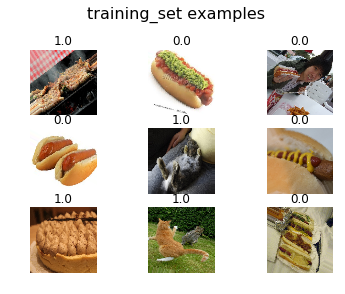

{'not-hotdog': 1, 'hotdog': 0}


In [11]:
from matplotlib import pyplot
%matplotlib inline
    
x,y = training_set.next()  # Generates BATCH_SIZE images on every invocation

# Only interested in a subset of the images
x = x[:9]
y = y[:9]

fig = pyplot.figure()
title = fig.suptitle('training_set examples', fontsize=16)
title.set_position([.5, 1.05])
for n, (img, title) in enumerate(zip(x,y)):
    a = fig.add_subplot(3, 3, n+1)
    pyplot.imshow(img)
    a.set_title(title)
    pyplot.axis('off')
#fig.set_dpi(300)
pyplot.show()

print(training_set.class_indices)

# 3. Build Convolutional Neural Network

### A Convolutional Neural Network (CNN) 

Each filter in a CNN, learns different characteristic of an image.

Keras allows us to specify the number of **filters** we want and the size of the filters. So, in our first layer, 32 is number of filters and (3, 3) is the size of the filter. We also need to specify the shape of the input which is (28, 28, 1), but we have to specify it only once.

The second layer is the **Activation layer**. We have used ReLU (rectified linear unit) as our activation function. ReLU function is f(x) = max(0, x), where x is the input. It sets all negative values in the matrix ‘x’ to 0 and keeps all the other values constant. It is the most used activation function since it reduces training time and prevents the problem of vanishing gradients.

The third layer is the **MaxPooling layer**. MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce overfitting. It also reduces the number of parameters to learn, reducing the training time.

After creating all the **convolutional layers**, we need to flatten them, so that they can act as an input to the Dense layers.

**Dense layers** are keras’s alias for Fully connected layers. These layers give the ability to classify the features learned by the CNN.

**Dropout** is the method used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. In our model, dropout will randomly disable 20% of the neurons.

The second last layer is the Dense layer with 1 neuron. The neurons in this layer should be equal to the number of classes we want to predict as this is the output layer.




In [12]:
K.set_learning_phase(1) # https://github.com/keras-team/keras/issues/2310
classifier = Sequential()

In [13]:
classifier.add(Conv2D(64, (3, 3), input_shape = (IMG_ROWS, IMG_COLS, IMG_CHANNELS), padding='same', activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Flatten())
classifier.add(Dense(64))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))


The cross-entropy loss calculates the error rate between the predicted value and the original value. The formula for calculating cross-entropy loss is given here. Because we have two classes we used binary_crossentropy.

The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is responsible for updating the weights of the neurons via backpropagation. It calculates the derivative of the loss function with respect to each weight and subtracts it from the weight. This is how a neural network learns.


In [14]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Save CNN as JSON


In [15]:
#serialize model to JSON
classifier_json = classifier.to_json()
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(classifier_json)
    

# 4. Train Convolutional Neural Network

### Metrics to monitor
When training your convolutional neural network you're monitoring two things at each epoch for both the training and validation stages: **accuracy**, and **loss**.  As you monitor these metrics hopefully the accuracy goes up and the loss goes down. 

When training it's possible to **underfit** and **overfit**. Underfitting occurs when the accuracy on the training set is lower then the accuracy on the validation set; a poor performing model. Overfitting occurs when the training loss contines to go down, but the validation loss continues to rise.

Finding the sweet spot between underfitting and overfitting is crucial to developing a model that generalizes well with unseen data.

**Dropout Regularization** is one method that's used to reduce overfitting. Dropout randomly turns off neurons during training, reducing their weight further down the network. This encourages the network to find additional neurons building separate representations of the class within the network. Increasing the dropout rate between layers combats against overfitting; a good starting point is between 0.20 and 0.50.  

#### *Finding the right balance is more of an art then science, and takes some time to experiment.*

![XKCD.com/1838](https://imgs.xkcd.com/comics/machine_learning.png)


### Setup callbacks to monitor metrics

**Callbacks** are functions applied at given stages of training. Below is an example demonstrating how to create a new callback, reporting the *validation loss* and *validation accuracy* at the end of each epoch.

Keras comes with many callback functions, including ModelCheckpoint used to save the weights after every epoch as seen below.

In [16]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
        print('-----------------------------------------------------------------------')
        print('Epoch ' + str(epoch) + ' - Validation loss: ' + str(logs.get('val_loss')) + ' accuracy : ' + str(logs.get('val_acc')))
        print('-----------------------------------------------------------------------')


In [17]:
checkpoint_all = ModelCheckpoint(filepath= MODEL_EPOCH_PATH, verbose=1, save_best_only=False)
checkpoint_best = ModelCheckpoint(filepath= MODEL_WEIGHTS_PATH, verbose=1, save_best_only=True)
loss_history = LossHistory()

In [18]:
history = classifier.fit_generator(training_set,
    steps_per_epoch = TRAINING_IMAGES//BATCH_SIZE,
    epochs = 50,
    validation_data = validation_set,
    validation_steps = VALIDATION_IMAGES//BATCH_SIZE,
    callbacks = [loss_history, checkpoint_all, checkpoint_best])

Epoch 1/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.4817 - acc: 0.7652-----------------------------------------------------------------------
Epoch 0 - Validation loss: 0.802923704569 accuracy : 0.692307692308
-----------------------------------------------------------------------
Epoch 00000: saving model to output_14-04-2018_1/seefood_weights-00-0.692307692308.hdf5
Epoch 00000: val_loss improved from inf to 0.80292, saving model to output_14-04-2018_1/seefood_model_weights.h5
1250/1250 [==============================] - 142s - loss: 0.4817 - acc: 0.7653 - val_loss: 0.8029 - val_acc: 0.6923
Epoch 2/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.4063 - acc: 0.8126-----------------------------------------------------------------------
Epoch 1 - Validation loss: 0.531526307647 accuracy : 0.788461538462
-----------------------------------------------------------------------
Epoch 00001: saving model to output_14-04-2018_1/seefood_weights-01-0.78846

1250/1250 [==============================] - 134s - loss: 0.2263 - acc: 0.9059 - val_loss: 0.6343 - val_acc: 0.7404
Epoch 16/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.2158 - acc: 0.9078-----------------------------------------------------------------------
Epoch 15 - Validation loss: 0.531765435178 accuracy : 0.8125
-----------------------------------------------------------------------
Epoch 00015: saving model to output_14-04-2018_1/seefood_weights-15-0.8125.hdf5
Epoch 00015: val_loss did not improve
1250/1250 [==============================] - 134s - loss: 0.2159 - acc: 0.9078 - val_loss: 0.5318 - val_acc: 0.8125
Epoch 17/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9113-----------------------------------------------------------------------
Epoch 16 - Validation loss: 0.693294776174 accuracy : 0.735576923077
-----------------------------------------------------------------------
Epoch 00016: saving model to output_14-04-2018

1250/1250 [==============================] - 134s - loss: 0.1534 - acc: 0.9354 - val_loss: 0.8891 - val_acc: 0.7284
Epoch 31/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9361-----------------------------------------------------------------------
Epoch 30 - Validation loss: 0.824628338218 accuracy : 0.78125
-----------------------------------------------------------------------
Epoch 00030: saving model to output_14-04-2018_1/seefood_weights-30-0.78125.hdf5
Epoch 00030: val_loss did not improve
1250/1250 [==============================] - 134s - loss: 0.1536 - acc: 0.9361 - val_loss: 0.8246 - val_acc: 0.7812
Epoch 32/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.1569 - acc: 0.9347-----------------------------------------------------------------------
Epoch 31 - Validation loss: 1.23311215639 accuracy : 0.735576923077
-----------------------------------------------------------------------
Epoch 00031: saving model to output_14-04-201

1250/1250 [==============================] - 134s - loss: 0.1215 - acc: 0.9510 - val_loss: 1.0849 - val_acc: 0.7572
Epoch 46/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9472-----------------------------------------------------------------------
Epoch 45 - Validation loss: 1.23497965717 accuracy : 0.747596153846
-----------------------------------------------------------------------
Epoch 00045: saving model to output_14-04-2018_1/seefood_weights-45-0.747596153846.hdf5
Epoch 00045: val_loss did not improve
1250/1250 [==============================] - 134s - loss: 0.1311 - acc: 0.9472 - val_loss: 1.2350 - val_acc: 0.7476
Epoch 47/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9469-----------------------------------------------------------------------
Epoch 46 - Validation loss: 0.579665449233 accuracy : 0.858173076923
-----------------------------------------------------------------------
Epoch 00046: saving model to ou

**Hyperparameter optimization is necessary to improve the models accuracy**

# 5. Evaluate Model

In [19]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 128)       0         
__________

### Plot Accuracy and Loss over Epochs
Plot the validation accuracy vs training accuracy, and the validation_loss vs training_loss

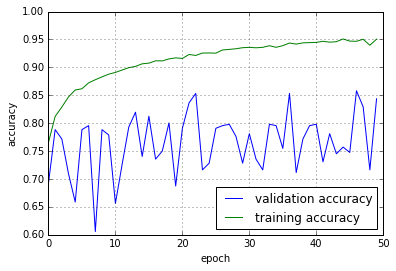

In [20]:

pyplot.plot(history.epoch,history.history['val_acc'],label='validation accuracy')
pyplot.plot(history.epoch,history.history['acc'],label='training accuracy')


pyplot.legend(loc=0)
pyplot.xlabel('epoch')
pyplot.ylabel('accuracy')
pyplot.grid(True)
pyplot.show()

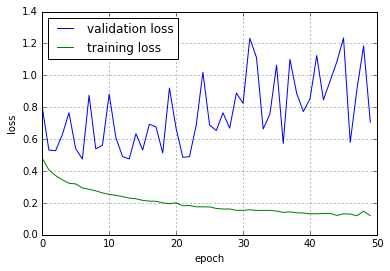

In [21]:
pyplot.plot(history.epoch,history.history['val_loss'],label='validation loss')
pyplot.plot(history.epoch,history.history['loss'],label='training loss')


pyplot.legend(loc=0)
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.grid(True)
pyplot.show()

### Load the best weights from the training 

In [22]:
model = get_best_model()

In [23]:
# The evaluate_generator method returns a tuple including the loss and accuracy of a model
results = model.evaluate_generator(validation_set, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[1]*100, results[0])) 

The model has a 93.75% accuracy, with a loss of 0.273087859154.


### Create a Confusion Matrix on with test data

It's important to test your model with data that hasn't been used during training for validation. 

|               |   **HOTDOG**   |  **NOTHOTDOG** |
| ------------- | -------------- | -------------- |
| **HOTDOG**    | True Positive  | False Positive |
| **NOTHOTDOG** | False Negative | True Negative  |

In [24]:
# Creating the Confusion Matrix on our test data

X_test, y_test = test_set.next()
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[187,  58],
       [ 49, 194]])

# 6. Make Predictions

In [25]:
#Load the best weights from the training 
model = get_best_model()

In [26]:
def make_prediction(model, img):
    """Display a list of images in a single plot with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    """
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis = 0)
    return model.predict(test_image, verbose=0)

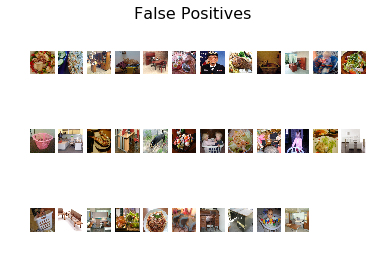

In [27]:
false_positives=[]
for file in os.listdir(TEST_DATA_PATH + '/nothotdog'):
    img = image.load_img(TEST_DATA_PATH + '/nothotdog/' + file, target_size = (IMG_COLS, IMG_COLS))
    if make_prediction(model, img) == HOTDOG:
        false_positives.append(img)     
 
show_images(false_positives, 3, title="False Positives")



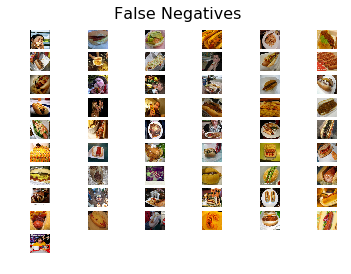

In [28]:
false_negatives=[]
for file in os.listdir(TEST_DATA_PATH + '/hotdog'):
    img = image.load_img(TEST_DATA_PATH + '/hotdog/' + file, target_size = (IMG_COLS, IMG_COLS))
    if make_prediction(model, img) == NOTHOTDOG:
        false_negatives.append(img)
        

show_images(false_negatives, 10, title="False Negatives")

### Download images from the web to evaluate model

In [29]:
!wget https://www.dietsinreview.com/diet_column/wp-content/uploads/2010/07/joey-chestnut-nathans-famous-hot-dog-eating-contest.jpg -O hotdog.jpg 

--2018-04-14 05:05:31--  https://www.dietsinreview.com/diet_column/wp-content/uploads/2010/07/joey-chestnut-nathans-famous-hot-dog-eating-contest.jpg
Resolving www.dietsinreview.com (www.dietsinreview.com)... 159.135.40.147
Connecting to www.dietsinreview.com (www.dietsinreview.com)|159.135.40.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15535 (15K) [image/jpeg]
Saving to: 'hotdog.jpg'

hotdog.jpg          100%[===================>]  15.17K  --.-KB/s    in 0s      

2018-04-14 05:05:31 (329 MB/s) - 'hotdog.jpg' saved [15535/15535]



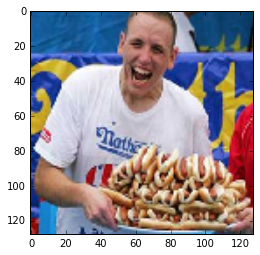

1/1 [==============================] - 0s
HOTDOG


In [30]:
test_image = image.load_img('hotdog.jpg', target_size = (IMG_ROWS, IMG_COLS))
pyplot.imshow(test_image)
pyplot.show()

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = classifier.predict(test_image, verbose=1)

print(CLASSIFICATION[int(result[0][0])])


In [31]:
!wget https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/dam/editorial/childrens-health/miscellaneous/how-to-change-teen-eating-habits/graphics/thumbnails/final/how-to-change-teen-eating-habits-375x321.jpg -O nothotdog.jpg

--2018-04-14 05:05:32--  https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/dam/editorial/childrens-health/miscellaneous/how-to-change-teen-eating-habits/graphics/thumbnails/final/how-to-change-teen-eating-habits-375x321.jpg
Resolving img.webmd.com (img.webmd.com)... 104.16.72.254, 104.16.71.254, 104.16.69.254, ...
Connecting to img.webmd.com (img.webmd.com)|104.16.72.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47399 (46K) [image/jpeg]
Saving to: 'nothotdog.jpg'

nothotdog.jpg       100%[===================>]  46.29K  --.-KB/s    in 0.001s  

2018-04-14 05:05:32 (57.2 MB/s) - 'nothotdog.jpg' saved [47399/47399]



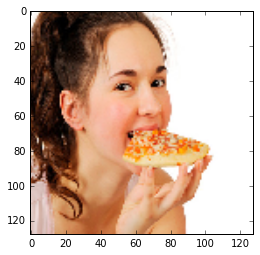

1/1 [==============================] - 0s
HOTDOG


In [32]:
test_image = image.load_img('nothotdog.jpg', target_size = (IMG_ROWS, IMG_COLS))
pyplot.imshow(test_image)
pyplot.show()

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = classifier.predict(test_image, verbose=1)

print(CLASSIFICATION[int(result[0][0])])

# 7. Take a closer look at generated filters
The CNN has several layers, including various filtering layers to identify important features of the image for the classification task. Let's look at the filters to see what areas of an image are identified as important for the hotdog, nothotdog classification
Inspired by code here: https://github.com/mingruimingrui/Convolution-neural-networks-made-easy-with-keras

In [33]:
model = get_best_model()

In [34]:
def get_layer_dict(model):
    return dict([(layer.name, layer) for layer in model.layers if (layer.name.find('dense') > -1) | (layer.name.find('conv') > -1)])

In [35]:
layers = get_layer_dict(model)
layers

{u'conv2d_1': <keras.layers.convolutional.Conv2D at 0x1104d2fe6790>,
 u'conv2d_2': <keras.layers.convolutional.Conv2D at 0x1104b7795950>,
 u'conv2d_3': <keras.layers.convolutional.Conv2D at 0x1104d31bfe50>,
 u'dense_1': <keras.layers.core.Dense at 0x1104d2d29ad0>,
 u'dense_2': <keras.layers.core.Dense at 0x1104d2a8d3d0>}

In [36]:
def deprocess_image(img):
    # normalize tensor: center on 0., ensure std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype('uint8')
    return img


In [37]:
def plot_hidden_filter_layers(model, layer, num_plot=16):
    _ = pyplot.suptitle(layer.name)

    # we shall only plot out 16(default) as there are too many filters to visualize

    layer_output = layer.output
    output_shape = layer.output_shape
    sub_plot_height = math.ceil(np.sqrt(num_plot))
    nb_filters = output_shape[len(output_shape) - 1]

    # here we need to conduct gradient acdent on each filter
    counter = 0
    for i in range(nb_filters):
        if counter < num_plot:
            # conv layers have different outputs than dense layers therefore different loss function sizes
            if layer.name.find('conv') != -1:
                loss = K.mean(layer_output[:,:,:,np.random.randint(nb_filters)])
            else:
                loss = K.mean(layer_output[:,np.random.randint(nb_filters)])

            # randomise initial input_img and calc gradient
            input_img = model.input#np.expand_dims(np.ones(X_shape[1:]), axis=0)
            grads = K.gradients(loss, input_img)[0]

            # normalize gradient
            grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

            # this function returns the loss and grads given the input picture
            iterate = K.function([input_img], [loss, grads])

            # we start from a gray image with some noise
            input_img_data = np.random.rand(1,IMG_ROWS, IMG_COLS, IMG_CHANNELS) * 0.1 + 0.5

            # run gradient ascdent for 20 steps
            for j in range(40):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value

            # deprocess_image and plot if found
            if loss_value > 0:
                img = deprocess_image(input_img_data[0])
                ax = pyplot.subplot(sub_plot_height, sub_plot_height, counter+1)
                _ = pyplot.axis('off')
                _ = ax.set_xticklabels([])
                _ = ax.set_yticklabels([])
                _ = ax.set_aspect('equal')
                _ = pyplot.imshow(img.squeeze(), cmap='inferno')

                counter += 1

    _ = pyplot.show()

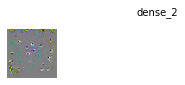

In [ ]:
for layer_name in layers:
    plot_hidden_filter_layers(model, layers[layer_name])

### Visualize image through each filter layer
Run an image through each convolutional layer and display the different filters applied to the image. Each filter focuses on features within the image. This gives you a better understanding of what the CNN is looking for when making it's final decision; hotdog or nothotdog.

In [ ]:
model = get_best_model()

In [ ]:
def get_image_from_generator():
    '''Generate some validation data and select a single sample image'''
    X, y = validation_set.next()
    img = X[0].reshape(-1,IMG_ROWS,IMG_COLS,IMG_CHANNELS)
    return img

In [ ]:
def get_conv_intermediate_layers(my_model):
    '''Returns the names of each convolutional layer in the model'''
    conv_layers = []
    for layer in my_model.layers:
        if 'conv' in layer.name:
            # Build a new model with the input from the original 
            # model, but with the output of specific layer.
            conv_layers.append(Model(inputs=my_model.input,
                                     outputs=my_model.get_layer(layer.name).output))            
    return conv_layers

In [ ]:
def plot_hidden_layers(my_model, img):
    to_visual = my_model.predict(img)
    to_visual = to_visual.reshape(to_visual.shape[1:])
    _ = pyplot.figure()

    sub_plot_height = math.ceil(np.sqrt(to_visual.shape[2]))
    for i in range(to_visual.shape[2]):
        ax = pyplot.subplot(sub_plot_height, sub_plot_height, i+1)
        _ = pyplot.axis('off')
        _ = ax.set_xticklabels([])
        _ = ax.set_yticklabels([])
        _ = ax.set_aspect('equal')
        _ = pyplot.imshow(to_visual[:, :, i], cmap='inferno')
        

In [ ]:
conv_models = get_conv_intermediate_layers(model)
img = get_image_from_generator()

_ = pyplot.imshow(img.reshape(img.shape[1:]))
_ = pyplot.title('Hotdog')

index = 0
for my_model in conv_models:
    index += 1
    
    plot_hidden_layers(my_model, img)

pyplot.show()

# 8. Convert Keras Model to Apple's coreML

#### Load the existing Keras model from disk

In [ ]:
# Load the best weights from the training 
model = get_best_model()

#### Set model properties and save as coreML

In [ ]:
output_labels = ['nothotdog']
coreml_model = coremltools.converters.keras.convert(MODEL_WEIGHTS_PATH, input_names='image',image_input_names = 'image',class_labels = output_labels)   
coreml_model.author = AUTHOR   
coreml_model.short_description = COREML_META_DESCRIPTION 
coreml_model.input_description['image'] = COREML_META_INPUT_DESCRIPTION


coreml_model.save(COREML_MODEL_PATH)

print coreml_model   